# Correct sense Identification using GLossGPT inspired prompting

In [1]:
# identify the meaning of the word using GLossGPT prompt template

from openai import OpenAI

client = OpenAI()

def get_model_output(Question):
  response = client.chat.completions.create(
    model='virtuoso-large',
    messages=[{'role': 'user', 'content': Question}],
    temperature=0.4,
  )

  return(response.choices[0].message.content)

In [ ]:
import csv
def main():
    file_path = 'Updated_train.csv'
    line_num = 1255
    with open(file_path, mode='r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            # Assign values from each row to variables
            homonym = row["homonym"]
            judged_meaning = row["judged_meaning"]
            precontext = row["precontext"]
            sentence = row["sentence"]
            ending = row["ending"]
            choice = row["choices"]
            example_sentence = row["example_sentence"]
            average = row["average"]

            prompt=f'''You are a helpful assitant to identify the corresponding meaning of an ambiguous word in a short story. Use multiple reasoning strategies to increase confidence in your answer.
1. The word "{homonym}" has different meanings.

2. The story is provided in three parts:
    i. Precontext: Few sentences grounding the story.
    ii. Ambiguous sentence: contains a homonym whose meaning may vary.
    iii. Optional ending: may imply a specific word sense.

3. Now carefully examine the story below. The ambiguous word is "{homonym}" is enclosed with the <WSD> tags.

i. Precontext: "{precontext}"
ii. Sentence: "{sentence}"
iii. Ending: "{ending}"

4. Now Analyze the sentence using the following techniques and identify the correct meaning of the ambiguous word.
   Focus on keywords in the pre context and the ending that may provide clues about the intended meaning of the homonym.
   Think about the overall story line. Decide on the sense of the word that makes the most logical sense within the context.

5. Return only the identified meaning in a explained way. Do not add extra details and explanation.'''

                        
        
                    
            # Generate response using the same format as training
            full_text = get_model_output(prompt)
            print(f"Line {line_num}: {full_text}")
            line_num += 1


if __name__ == "__main__":
    main()

In [10]:
# uncertanitity in the response generation calculation
import ast
import csv
def main():
    file_path = 'Updated_train.csv'
    clear_count = 0
    unclear_count = 0
    average_count = 0
    with open(file_path, mode='r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            # Assign values from each row to variables            
            choice = ast.literal_eval( row["choices"]) #converting string to list
            
            count = max(choice) - min(choice)
            if count <= 1:
                clear_count += 1
            elif count == 2:
                average_count += 1
            else:
                unclear_count += 1

    print(f"Clear: {clear_count}, Average: {average_count}, Unclear: {unclear_count}")
    csvfile.close()

            


if __name__ == "__main__":
    main()

Clear: 765, Average: 580, Unclear: 935


In [4]:
import pandas as pd
import numpy as np
import ast

# --- load your CSV ---
df = pd.read_csv('Updated_dev.csv')

# compute per-instance stats from 'choices'
def instance_human_scores(row):
    if isinstance(row['choices'], str):
        ratings = ast.literal_eval(row['choices'])
    else:
        ratings = row['choices']
    ratings = np.array(ratings, dtype=float)
    
    mu = ratings.mean()
    sigma = ratings.std(ddof=0)
    mu_norm = (mu - 1) / 4.0
    U_human = 1.0 - mu_norm
    D = sigma / 2.0
    consensus_prop = np.mean(ratings >= 4)
    return pd.Series({
        'mu': mu,
        'mu_norm': mu_norm,
        'sigma': sigma,
        'U_human': U_human,
        'D': D,
        'consensus_prop': consensus_prop
    })

df_scores = df.apply(instance_human_scores, axis=1)
df = pd.concat([df, df_scores], axis=1)

# labeling with reasons
def human_label_with_reason(mu, sigma):
    if mu >= 4.0 and sigma <= 1.0:
        return "HumanEasy", "high_mean_low_disagreement"
    if mu < 2.0 and sigma <= 1.0:
        return "HumanEasy", "low_mean_low_disagreement"
    # ambiguous cases
    if mu < 4.0 and mu > 2.0:
        return "HumanAmbiguous", "moderate_mean"
    if sigma > 1.0:
        return "HumanAmbiguous", "high_disagreement"
    # fallback
    return "HumanAmbiguous", "mixed_case"

df[['human_label', 'label_reason']] = df.apply(
    lambda r: pd.Series(human_label_with_reason(r['mu'], r['sigma'])), axis=1
)

# summary
print(df[['mu','sigma','human_label','label_reason']].head())
print(df['human_label'].value_counts())

# --- IGNORE ---
#printing the human label dataframe

print(df['human_label'])


    mu     sigma     human_label                label_reason
0  3.6  1.496663  HumanAmbiguous               moderate_mean
1  3.6  0.489898  HumanAmbiguous               moderate_mean
2  3.8  1.166190  HumanAmbiguous               moderate_mean
3  4.2  0.748331       HumanEasy  high_mean_low_disagreement
4  3.0  1.673320  HumanAmbiguous               moderate_mean
human_label
HumanAmbiguous    331
HumanEasy         257
Name: count, dtype: int64
0      HumanAmbiguous
1      HumanAmbiguous
2      HumanAmbiguous
3           HumanEasy
4      HumanAmbiguous
            ...      
583         HumanEasy
584    HumanAmbiguous
585         HumanEasy
586    HumanAmbiguous
587    HumanAmbiguous
Name: human_label, Length: 588, dtype: object


In [1]:
import pandas as pd
import numpy as np
import ast

# --- load your CSV ---
df = pd.read_csv('Updated_dev.csv')

# compute per-instance stats from 'choices'
def instance_human_scores(row):
    if isinstance(row['choices'], str):
        ratings = ast.literal_eval(row['choices'])
    else:
        ratings = row['choices']
    ratings = np.array(ratings, dtype=float)
    
    mu = ratings.mean()
    sigma = ratings.std(ddof=0)
    mu_norm = (mu - 1) / 4.0
    U_human = 1.0 - mu_norm
    D = sigma / 2.0
    consensus_prop = np.mean(ratings >= 4)
    return pd.Series({
        'mu': mu,
        'mu_norm': mu_norm,
        'sigma': sigma,
        'U_human': U_human,
        'D': D,
        'consensus_prop': consensus_prop
    })

df_scores = df.apply(instance_human_scores, axis=1)
df = pd.concat([df, df_scores], axis=1)

# labeling with reasons
def human_label_with_reason(mu, sigma):
    if sigma <=0.5:
        return "HumanEasy", "low_disagreement"
    else:
        return "HumanAmbiguous", "high_disagreement"
    

df[['human_label', 'label_reason']] = df.apply(
    lambda r: pd.Series(human_label_with_reason(r['mu'], r['sigma'])), axis=1
)

# summary
print(df[['mu','sigma','human_label','label_reason']].head())
print(df['human_label'].value_counts())

# --- IGNORE ---
#printing the human label dataframe

print(df['human_label'])

    mu     sigma     human_label       label_reason
0  3.6  1.496663  HumanAmbiguous  high_disagreement
1  3.6  0.489898       HumanEasy   low_disagreement
2  3.8  1.166190  HumanAmbiguous  high_disagreement
3  4.2  0.748331  HumanAmbiguous  high_disagreement
4  3.0  1.673320  HumanAmbiguous  high_disagreement
human_label
HumanAmbiguous    393
HumanEasy         195
Name: count, dtype: int64
0      HumanAmbiguous
1           HumanEasy
2      HumanAmbiguous
3      HumanAmbiguous
4      HumanAmbiguous
            ...      
583    HumanAmbiguous
584    HumanAmbiguous
585         HumanEasy
586    HumanAmbiguous
587    HumanAmbiguous
Name: human_label, Length: 588, dtype: object


In [2]:
#save as a new file to keep original intact
df.to_csv("Updated_dev_with_sigma_score.csv", index=False)

print("File saved with new columns:", ["mu", "sigma", "human_label", "label_reason"])


File saved with new columns: ['mu', 'sigma', 'human_label', 'label_reason']


# Implementation for Version Evaluation

In [2]:
import re

def mark_word_with_wsd(word, sentence):
    """
    Encloses the first occurrence of a given word (or its variations) in a sentence
    with <WSD>...</WSD> tags.

    Handles:
    - Case-insensitive matching
    - Word variations like 'drive' -> 'drives', 'driving', 'driven'
    - Punctuation immediately following the word
    """
    if not word or not sentence:
        return sentence  # Return as-is if input is empty

    # Create a regex pattern to match the word plus common suffixes
    pattern = re.compile(rf"\b({re.escape(word)}\w*)\b", re.IGNORECASE)

    # Replace only the first match
    return pattern.sub(r"<WSD>\1</WSD>", sentence, count=1)

In [3]:
# This code is utilized to convert a JSON file into a CSV file with specific columns. (for dev.json)
import json
import pandas as pd

# Load the JSON data
with open('test.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Prepare a list to hold the transformed rows
rows = []

for key, item in data.items():
    homonym = item.get('homonym', '')
    sentence = item.get('sentence', '')

    row = {
        'homonym': homonym,
        'judged_meaning': item.get('judged_meaning', ''),
        'precontext': item.get('precontext', ''),
        'sentence': mark_word_with_wsd(homonym, sentence),
        'ending': item.get('ending', ''),
        'choices': item.get('choices', ''),
        'average': item.get('average', ''),
        'stdev': item.get('stdev', ''),
        'nonsensical': item.get('nonsensical', ''),
        'sample_id': item.get('sample_id', ''),
        'example_sentence': item.get('example_sentence', '')
    }

    rows.append(row)

# Create a DataFrame and save as CSV
df = pd.DataFrame(rows, columns=[
    'homonym', 'judged_meaning', 'precontext', 'sentence', 'ending',
    'choices', 'average', 'stdev', 'nonsensical', 'sample_id', 'example_sentence'
])
df.to_csv('Updated_test.csv', index=False)


In [10]:
# This code is utilized to convert a JSON file into a CSV file with specific columns. (for train.json)
import json
import pandas as pd

# Load the JSON data
with open('train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Prepare a list to hold the transformed rows
rows = []

# Iterate over the values (each one is a dictionary)

for key, item in data.items():
    homonym = item.get('homonym', '')
    sentence = item.get('sentence', '')

    row = {
        'homonym': homonym,
        'judged_meaning': item.get('judged_meaning', ''),
        'precontext': item.get('precontext', ''),
        'sentence': mark_word_with_wsd(homonym, sentence),
        'ending': item.get('ending', ''),
        'choices': item.get('choices', ''),
        'average': item.get('average', ''),
        'stdev': item.get('stdev', ''),
        'nonsensical': item.get('nonsensical', ''),
        'sample_id': item.get('sample_id', ''),
        'example_sentence': item.get('example_sentence', '')
    }

    rows.append(row)

# Create a DataFrame and save as CSV
df = pd.DataFrame(rows, columns=[
    'homonym', 'judged_meaning', 'precontext', 'sentence', 'ending',
    'choices', 'average', 'stdev', 'nonsensical', 'sample_id', 'example_sentence'
])
df.to_csv('Updated_train.csv', index=False)

In [ ]:
# Prompt Design

Prompt= f'''You are an assistant simulating human judgment to rate the plausibility of a word sense in a short story. Each story consists of:

1. Precontext: Few sentences grounding the story.
2. Ambiguous sentence: contains a homonym whose meaning may vary.
3. Optional ending: may imply a specific word sense.

For each story, you should evaluate the plausibility of a specified word sense for the homonym using a 1–5 scale (1 = highly implausible, 5 = highly plausible). Simulate the judgment process of 5 human raters, and then provide a single final integer plausibility score between 1 and 5. Do not provide any justifications or explanations.

Example story:  
Homonym: "track"
Precontext: "The detectives arrived at the abandoned train station. They were looking for signs of the missing artifact. A faint trail caught their attention."  
Sentence: "They followed the track."  
Ending: "They began to run along the abandoned railway line, hopping from wooden sleeper to sleeper to avoid twisting an ankle."  

Judged meaning for homonym "track": "a pair of parallel rails providing a runway for wheels."  
Example usage: "The train glided smoothly along the track."

Return only the final integer plausibility score.
'''

# Data Visualization

In [2]:
import pandas as pd

gold_final_score = []
with open('train.csv', 'r', encoding='utf-8') as f:
    df = pd.read_csv(f)
    for index, row in df.iterrows():
        average = row['average']
        gold_final_score.append(average)       
        
print(gold_final_score)

[3.0, 3.8, 2.2, 4.4, 2.6, 4.2, 3.8, 4.2, 1.4, 4.6, 2.8, 4.8, 4.0, 1.8, 2.8, 3.8, 3.8, 2.6, 5.0, 1.6, 3.8, 2.6, 5.0, 1.6, 4.4, 1.8, 1.2, 4.2, 2.4, 1.8, 5.0, 1.6, 2.2, 3.0, 5.0, 2.0, 2.4, 1.0, 1.6, 2.0, 1.0, 1.2, 3.6, 1.6, 3.2, 2.0, 4.4, 2.2, 4.6, 1.0, 2.4, 3.4, 3.4, 3.8, 3.8, 3.0, 2.0, 4.0, 2.0, 2.6, 1.8, 4.2, 1.0, 5.0, 1.2, 4.6, 4.4, 2.0, 1.8, 3.6, 3.8, 1.6, 3.8, 2.2, 4.0, 2.0, 4.2, 1.0, 3.0, 1.8, 4.6, 2.0, 4.6, 1.6, 4.6, 2.2, 4.6, 2.6, 4.8, 2.6, 3.8, 4.4, 2.6, 4.833333333333333, 2.6, 4.0, 4.6, 1.8, 1.6, 3.4, 2.6, 3.2, 4.6, 1.8, 2.6, 3.2, 2.0, 2.4, 4.2, 4.4, 3.2, 4.2, 3.4, 4.2, 3.0, 2.2, 3.0, 2.8, 4.0, 3.2, 4.0, 2.0, 4.8, 2.6, 3.0, 3.8, 4.8, 2.6, 2.6, 3.4, 3.8, 2.8, 4.4, 1.5, 2.6, 4.6, 3.4, 1.8, 1.8, 4.4, 1.0, 5.0, 2.4, 4.2, 1.8, 3.4, 1.4, 4.4, 1.8, 3.8, 4.6, 2.2, 3.0, 2.6, 4.0, 1.6, 4.6, 3.0, 2.0, 4.2, 2.6, 3.2, 3.4, 2.0, 3.0, 3.2, 3.4, 3.6, 5.0, 3.0, 2.2, 3.0, 3.6, 2.8, 4.2, 2.4, 2.333333333333333, 4.6, 4.6, 2.0, 4.0, 3.2, 1.8, 4.8, 2.4, 3.6, 3.2, 3.2, 3.0, 4.4, 2.4, 2.6, 2.6, 3.2, 3

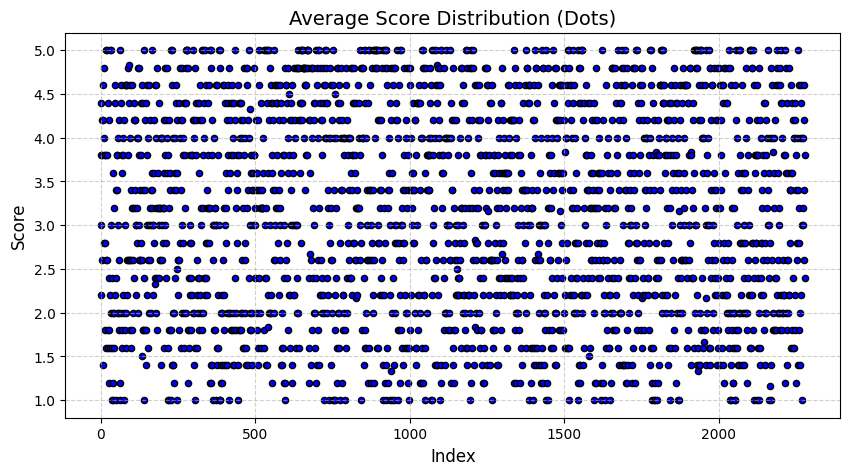

In [5]:
import matplotlib.pyplot as plt


# Plotting a scatter plot (dots only)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(gold_final_score)), gold_final_score, color='blue', s=20, edgecolor='black')
plt.title("Average Score Distribution (Dots)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Evaluation

In [1]:
import pandas as pd

gold_final_score = []
with open('dev.csv', 'r', encoding='utf-8') as f:
    df = pd.read_csv(f)
    for index, row in df.iterrows():
        average = row['average']
        gold_final_score.append(average)       
        

print(gold_final_score)
print(len(gold_final_score))

[3.6, 3.6, 3.8, 4.2, 3.0, 3.0, 4.6, 1.3333333333333333, 2.2, 3.8, 3.2, 2.2, 4.0, 3.0, 2.2, 2.4, 3.4, 2.0, 4.6, 1.2, 2.2, 4.8, 3.2, 3.0, 2.4, 2.6, 3.8, 1.8, 3.0, 2.8, 4.4, 2.0, 4.6, 2.4, 4.8, 2.8, 4.4, 1.2, 3.8, 1.8, 4.4, 1.6, 1.8, 2.4, 1.2, 5.0, 2.0, 3.4, 5.0, 1.0, 1.6, 3.0, 4.8, 1.8, 4.8, 1.0, 2.2, 4.0, 3.0, 2.6, 5.0, 2.6666666666666665, 4.6, 1.2, 4.4, 1.8, 4.0, 2.4, 2.0, 5.0, 2.6, 4.4, 3.8, 1.2, 3.0, 3.4, 4.0, 2.4, 5.0, 1.6, 5.0, 1.0, 4.4, 2.0, 4.4, 2.0, 1.8, 4.4, 4.8, 1.2, 4.2, 4.2, 1.8, 4.6, 2.0, 4.0, 4.8, 2.0, 4.8, 1.8, 5.0, 1.0, 4.8, 2.2, 4.6, 1.2, 5.0, 2.2, 3.8, 1.6, 3.2, 4.0, 2.8, 3.2, 4.8, 1.4, 5.0, 3.0, 5.0, 1.4, 4.0, 1.4, 2.6, 3.0, 3.0, 2.0, 3.6, 2.6, 1.8, 3.8, 2.8, 3.8, 4.0, 3.0, 1.8, 4.2, 2.6, 3.6, 3.4, 3.2, 2.6, 4.6, 2.8, 3.6, 3.6, 2.4, 5.0, 1.8, 3.8, 1.4, 4.0, 3.0, 4.2, 2.6, 3.6, 3.6, 4.4, 3.0, 1.8, 4.4, 2.0, 4.2, 3.8, 1.0, 3.0, 1.4, 4.0, 1.2, 3.8, 2.4, 2.6, 4.0, 2.0, 3.4, 3.2, 1.8, 2.0, 2.8, 3.2, 3.4, 4.2, 3.0, 2.6, 4.0, 2.6, 4.2, 2.2, 4.4, 2.4, 4.6, 2.2, 4.0, 4.8, 1.4,

In [2]:
import re

def extract_numbers_and_score(text: str):
    # Extract the first array of numbers inside square brackets
    array_match = re.search(r"\[(.*?)\]", text)
    number_array = []
    if array_match:
        number_array = [int(num.strip()) for num in array_match.group(1).split(",")]

    # Extract the last integer in the text (final plausibility score)
    final_score_match = re.search(r"(\d+)(?!.*\d)", text)  # last number in the string
    final_score = int(final_score_match.group(1)) if final_score_match else None

    return final_score, number_array


In [14]:
# Gemma with 5 annotator simulation and Final score extraction
Gemma_final_score = []
Gemma_final_array = []

with open ('Gemma.8095654', 'r', encoding='utf-8') as f:
    for line in f:
        final_score, number_array = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        Gemma_final_array.append(number_array)
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)
print(len(Gemma_final_score))
print(Gemma_final_array)
print(len(Gemma_final_array))

[2, 3, 2, 2, 1, 5, 4, 1, 1, 2, 5, 2, 2, 2, 1, 4, 2, 2, 5, 2, 5, 1, 2, 1, 5, 1, 5, 1, 5, 2, 4, 1, 5, 5, 3, 1, 1, 5, 3, 4, 5, 1, 5, 5, 5, 5, 5, 5, 2, 2, 3, 2, 5, 2, 5, 1, 3, 3, 2, 1, 1, 1, 2, 1, 1, 3, 1, 1, 4, 5, 1, 1, 3, 2, 1, 1, 1, 3, 1, 2, 5, 1, 1, 1, 1, 1, 1, 5, 3, 5, 1, 1, 5, 4, 2, 2, 5, 3, 3, 1, 3, 1, 4, 2, 3, 1, 5, 2, 4, 2, 2, 2, 5, 4, 2, 1, 2, 1, 2, 3, 5, 2, 2, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3, 5, 3, 5, 5, 3, 4, 5, 4, 4, 1, 5, 4, 5, 2, 5, 5, 2, 3, 2, 5, 5, 4, 3, 5, 4, 2, 5, 5, 4, 5, 5, 2, 2, 5, 2, 5, 1, 5, 1, 5, 1, 2, 4, 5, 2, 5, 3, 5, 1, 2, 3, 5, 4, 5, 4, 2, 5, 3, 5, 4, 2, 5, 2, 5, 4, 5, 3, 2, 5, 3, 2, 1, 5, 2, 5, 1, 3, 4, 5, 2, 2, 4, 4, 2, 4, 4, 4, 1, 5, 5, 3, 2, 5, 5, 5, 1, 5, 3, 2, 5, 5, 2, 3, 5, 5, 5, 5, 1, 5, 1, 5, 3, 3, 2, 3, 5, 4, 5, 5, 3, 3, 3, 5, 1, 5, 2, 5, 2, 3, 4, 1, 5, 1, 5, 2, 5, 5, 5, 4, 5, 5, 5, 5, 3, 4, 5, 4, 2, 2, 1, 2, 5, 5, 4, 5, 3, 5, 2, 3, 1, 2, 4, 5, 2, 4, 4, 2, 3, 2, 5, 4, 5, 1, 2, 1, 3, 5, 1, 2, 2, 5, 5, 5, 1, 4, 5, 5, 5, 3, 2, 1, 2, 2, 

In [15]:
difference = 0
for golf, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(golf - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.4710884353741496
Spearman Correlation: 0.1266
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4524


In [35]:
difference = 0
Gemma_final_score = []
for golf, predict in zip(gold_final_score, Gemma_final_array):
    p = max(predict)
    Gemma_final_score.append(p)
    diff = abs(golf - p)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.5928571428571434
Spearman Correlation: 0.1111
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4014


In [42]:
difference = 0
Gemma_final_score = []
for golf, predict in zip(gold_final_score, Gemma_final_array):
    p = sum(predict) / len(predict)
    Gemma_final_score.append(p)
    diff = abs(golf - p)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.3941421012849597
Spearman Correlation: 0.1280
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4541


In [18]:
Qwen_final_score = []
Qwen_final_array = []

with open ('Qwen.8095653', 'r', encoding='utf-8') as f:
    for line in f:
        final_score, number_array = extract_numbers_and_score(line)
        Qwen_final_score.append(final_score)
        Qwen_final_array.append(number_array)
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Qwen_final_score)
print(len(Qwen_final_score))
print(Qwen_final_array)
print(len(Qwen_final_array))

[2, 2, 1, 5, 2, 3, 5, 1, 2, 2, 2, 2, 5, 3, 1, 2, 2, 1, 5, 1, 2, 1, 2, 2, 5, 3, 5, 1, 5, 4, 5, 1, 5, 1, 5, 5, 1, 1, 5, 1, 5, 1, 2, 2, 3, 2, 3, 5, 5, 1, 5, 2, 3, 2, 5, 2, 5, 2, 5, 1, 2, 3, 5, 1, 4, 4, 2, 1, 2, 1, 2, 2, 2, 4, 1, 2, 2, 1, 5, 1, 4, 2, 5, 2, 3, 1, 5, 5, 3, 5, 4, 4, 1, 3, 5, 5, 2, 1, 5, 1, 5, 5, 2, 2, 3, 5, 2, 5, 2, 4, 2, 5, 5, 5, 5, 3, 2, 2, 5, 5, 2, 1, 2, 2, 4, 2, 4, 5, 5, 5, 5, 2, 3, 5, 2, 5, 2, 5, 2, 5, 1, 5, 4, 5, 2, 1, 5, 1, 5, 3, 5, 3, 1, 4, 1, 5, 2, 4, 1, 5, 1, 5, 5, 1, 5, 4, 2, 2, 5, 1, 5, 3, 4, 4, 1, 1, 5, 3, 3, 5, 3, 5, 5, 5, 2, 5, 2, 5, 5, 5, 4, 2, 2, 3, 5, 5, 5, 1, 4, 1, 5, 5, 5, 5, 2, 5, 3, 4, 5, 4, 5, 2, 1, 2, 5, 5, 4, 2, 5, 4, 5, 5, 2, 3, 3, 3, 3, 1, 1, 5, 2, 4, 3, 5, 1, 2, 2, 1, 1, 5, 5, 3, 1, 3, 1, 5, 3, 3, 5, 1, 5, 3, 5, 5, 3, 4, 5, 4, 5, 3, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 3, 5, 1, 5, 1, 3, 1, 2, 2, 1, 1, 1, 1, 3, 1, 2, 2, 5, 5, 2, 5, 2, 4, 5, 5, 2, 5, 1, 5, 1, 1, 3, 4, 5, 2, 5, 3, 3, 5, 5, 5, 5, 3, 2, 5, 1, 5, 1, 2, 3, 5, 1, 5, 1, 1, 1, 5, 2, 4, 1, 5, 5, 2, 

In [19]:
difference = 0
for golf, predict in zip(gold_final_score, Qwen_final_score):
    diff = abs(golf - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.313605442176872
Spearman Correlation: 0.3160
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4983


In [43]:
difference = 0
Qwen_final_score = []
for golf, predict in zip(gold_final_score, Qwen_final_array):
    p = max(predict)
    Qwen_final_score.append(p)
    diff = abs(golf - p)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.390589569160998
Spearman Correlation: 0.2981
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4881


In [44]:
difference = 0
Qwen_final_score = []
for golf, predict in zip(gold_final_score, Qwen_final_array):
    p = sum(predict) / len(predict)
    Qwen_final_score.append(p)
    diff = abs(golf - p)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.2489795918367352
Spearman Correlation: 0.3144
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.5102


# V2 Answer

In [2]:
#simlation of single annotator
import re

def extract_numbers_and_score(text: str):
    # Extract the first array of numbers inside square brackets
    array_match = re.search(r"\[(.*?)\]", text)
    

    # Extract the last integer in the text (final plausibility score)
    final_score_match = re.search(r"(\d+)(?!.*\d)", text)  # last number in the string
    final_score = int(final_score_match.group(1)) if final_score_match else None

    return final_score

In [ ]:
Gemma_final_score = []


with open ('GemmaV2.8096175', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)



In [24]:
difference = 0
for golf, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(golf - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.1878684807256237
Spearman Correlation: 0.2413
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.5816


In [32]:
Gemma_final_score = []


with open ('GemmaV2.8096177', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)





[5, 4, 3, 4, 2, 4, 2, 2, 1, 5, 2, 4, 2, 2, 3, 1, 4, 1, 4, 2, 4, 2, 5, 2, 3, 1, 4, 2, 4, 2, 4, 2, 5, 2, 4, 2, 4, 1, 2, 2, 5, 3, 1, 3, 3, 3, 1, 3, 2, 1, 2, 3, 4, 1, 5, 2, 4, 3, 4, 5, 2, 2, 3, 3, 3, 5, 4, 1, 4, 5, 5, 4, 5, 2, 2, 2, 5, 5, 3, 2, 4, 2, 4, 2, 5, 1, 1, 3, 3, 2, 2, 3, 4, 5, 2, 3, 5, 1, 4, 2, 4, 5, 2, 3, 4, 2, 4, 3, 5, 4, 2, 2, 2, 2, 3, 1, 5, 5, 2, 3, 4, 4, 4, 4, 4, 2, 3, 4, 2, 4, 4, 4, 2, 5, 4, 5, 5, 4, 5, 5, 2, 4, 5, 4, 4, 5, 3, 3, 2, 3, 3, 4, 3, 3, 3, 4, 5, 4, 2, 2, 4, 3, 4, 5, 2, 5, 4, 2, 5, 2, 4, 4, 4, 4, 1, 2, 2, 2, 3, 4, 3, 5, 5, 2, 3, 5, 4, 4, 2, 3, 2, 5, 5, 5, 3, 3, 5, 4, 4, 4, 4, 4, 5, 4, 5, 5, 3, 2, 5, 5, 3, 1, 2, 2, 2, 2, 4, 5, 5, 5, 2, 2, 2, 3, 3, 2, 2, 3, 2, 1, 3, 5, 2, 4, 5, 4, 4, 5, 4, 3, 4, 5, 4, 4, 4, 4, 4, 3, 5, 1, 3, 2, 5, 2, 4, 2, 4, 2, 5, 2, 5, 2, 3, 1, 5, 2, 2, 3, 2, 2, 2, 4, 5, 4, 5, 2, 2, 3, 1, 5, 3, 1, 4, 4, 1, 3, 3, 3, 4, 1, 3, 1, 5, 5, 5, 2, 4, 5, 4, 2, 4, 3, 3, 4, 4, 5, 2, 4, 3, 2, 3, 5, 4, 2, 5, 5, 5, 2, 3, 4, 4, 4, 4, 3, 5, 2, 3, 1, 4, 5, 3, 5, 2, 

In [33]:
difference = 0
for golf, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(golf - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.1848072562358283
Spearman Correlation: 0.2794
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.5595


# Qwen Version 2

In [28]:
Qwen_final_score = []


with open ('Qwen V2.8096652', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Qwen_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Qwen_final_score)

[5, 5, 1, 4, 4, 4, 1, 1, 1, 2, 4, 3, 3, 1, 2, 3, 3, 3, 5, 4, 3, 2, 4, 1, 3, 1, 3, 2, 5, 1, 4, 3, 5, 2, 5, 1, 4, 1, 3, 4, 2, 2, 2, 3, 2, 4, 4, 1, 4, 2, 5, 2, 3, 1, 4, 1, 2, 5, 4, 1, 5, 1, 3, 1, 5, 1, 2, 1, 5, 3, 4, 3, 4, 1, 3, 2, 5, 2, 5, 1, 4, 1, 4, 3, 4, 4, 3, 2, 3, 2, 2, 4, 2, 4, 3, 3, 3, 4, 5, 4, 5, 1, 5, 5, 5, 4, 4, 3, 3, 2, 3, 4, 4, 2, 3, 3, 4, 2, 3, 3, 4, 3, 3, 4, 5, 2, 5, 5, 5, 5, 3, 4, 2, 5, 3, 5, 3, 4, 3, 4, 3, 4, 2, 3, 3, 5, 4, 4, 5, 2, 5, 3, 5, 5, 5, 5, 3, 5, 1, 5, 2, 4, 4, 2, 3, 3, 4, 5, 3, 4, 3, 4, 4, 4, 4, 1, 2, 4, 4, 4, 5, 2, 2, 4, 4, 5, 3, 5, 2, 4, 4, 3, 4, 4, 3, 5, 3, 1, 4, 3, 5, 1, 3, 2, 5, 3, 2, 2, 4, 2, 5, 2, 2, 2, 2, 3, 3, 4, 3, 2, 5, 3, 1, 1, 5, 3, 5, 4, 3, 5, 3, 4, 4, 3, 4, 2, 5, 4, 1, 4, 2, 3, 4, 5, 2, 5, 4, 3, 4, 2, 3, 3, 4, 5, 4, 2, 2, 3, 4, 2, 5, 1, 5, 1, 3, 2, 5, 2, 4, 5, 3, 4, 1, 5, 3, 4, 3, 1, 3, 2, 1, 2, 4, 2, 5, 2, 5, 3, 4, 3, 4, 2, 4, 3, 5, 2, 4, 3, 2, 2, 3, 5, 5, 5, 2, 4, 4, 4, 3, 3, 4, 4, 2, 3, 2, 2, 4, 3, 3, 2, 3, 1, 2, 2, 2, 3, 4, 1, 2, 3, 1, 2, 2, 

In [29]:
difference = 0
for golf, predict in zip(gold_final_score, Qwen_final_score):
    diff = abs(golf - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.1895691609977328
Spearman Correlation: 0.2653
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.5646


# base model Evaluation

In [30]:
#Qwen Base model
Qwen_final_score = []


with open ('Qwen base.8096729', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Qwen_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Qwen_final_score)

[3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3, 2, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4, 2, 3, 3, 3, 

In [31]:
difference = 0
for gold, predict in zip(gold_final_score, Qwen_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

0.9689342403628118
Spearman Correlation: 0.2789
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.6105


In [9]:
#Gemma Base model
Gemma_final_score = []


with open ('gemmaBase.8096727', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)
print(len(Gemma_final_score))

[3, 3, 3, 5, 5, 5, 5, 3, 3, 5, 5, 5, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3, 3, 3, 3, 5, 5, 3, 5, 4, 5, 5, 3, 5, 5, 5, 3, 4, 5, 5, 3, 3, 5, 3, 5, 3, 4, 4, 3, 3, 4, 5, 3, 5, 5, 3, 4, 3, 5, 3, 2, 5, 5, 3, 5, 3, 2, 3, 5, 5, 5, 3, 3, 5, 5, 3, 5, 3, 3, 5, 5, 5, 5, 3, 5, 5, 4, 2, 5, 5, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 5, 3, 2, 5, 4, 5, 3, 4, 5, 5, 5, 5, 3, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 3, 5, 3, 5, 3, 3, 5, 3, 5, 3, 5, 5, 5, 5, 5, 4, 5, 2, 3, 3, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 4, 3, 3, 1, 5, 5, 5, 5, 3, 3, 5, 5, 5, 3, 5, 5, 5, 4, 5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 4, 4, 2, 5, 4, 4, 5, 4, 3, 5, 5, 5, 5, 5, 5, 3, 5, 4, 5, 5, 5, 3, 5, 4, 5, 5, 4, 5, 3, 3, 5, 1, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 4, 5, 5, 5, 4, 4, 5, 3, 5, 5, 5, 4, 3, 3, 5, 3, 1, 5, 4, 4, 5, 5, 5, 3, 3, 3, 4, 5, 3, 3, 5, 5, 5, 5, 3, 5, 5, 4, 4, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 3, 4, 1, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 3, 4, 3, 3, 5, 3, 3, 5, 

In [10]:
difference = 0
for gold, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")


1.5435374149659864
Spearman Correlation: 0.0337
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.4235


# Version 3 Evaluation

In [5]:
Gemma_final_score = []


with open ('Gemma_v3_results.8097404', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)
print(len(Gemma_final_score))

[4, 2, 2, 4, 1, 5, 4, 1, 2, 2, 3, 2, 1, 3, 3, 3, 2, 3, 3, 1, 1, 2, 4, 3, 1, 1, 5, 4, 4, 2, 4, 3, 4, 1, 3, 1, 5, 3, 3, 1, 4, 2, 1, 5, 3, 5, 2, 3, 4, 1, 3, 2, 4, 3, 3, 3, 4, 3, 3, 2, 3, 1, 5, 2, 4, 2, 4, 3, 5, 3, 3, 1, 4, 4, 1, 5, 3, 4, 5, 1, 5, 1, 5, 3, 2, 1, 2, 4, 4, 5, 1, 4, 2, 5, 5, 3, 2, 1, 4, 2, 5, 2, 4, 2, 3, 4, 1, 3, 3, 4, 2, 5, 2, 2, 4, 4, 2, 3, 4, 2, 4, 1, 5, 4, 4, 2, 4, 3, 4, 4, 2, 3, 1, 4, 1, 2, 3, 5, 3, 5, 2, 5, 3, 5, 2, 2, 5, 2, 4, 2, 3, 4, 3, 5, 5, 4, 2, 3, 4, 4, 2, 3, 3, 5, 1, 2, 3, 3, 3, 4, 1, 5, 2, 4, 2, 2, 2, 5, 3, 2, 3, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 5, 5, 5, 4, 3, 5, 2, 2, 2, 2, 5, 3, 3, 5, 2, 2, 2, 2, 3, 4, 1, 3, 1, 2, 3, 2, 4, 4, 4, 3, 3, 2, 1, 2, 4, 2, 1, 3, 5, 2, 4, 2, 3, 5, 2, 2, 1, 3, 3, 2, 5, 2, 5, 3, 5, 4, 1, 3, 3, 5, 3, 2, 1, 2, 4, 2, 2, 3, 2, 3, 4, 5, 1, 5, 2, 4, 2, 5, 2, 2, 2, 5, 1, 2, 1, 4, 2, 2, 3, 3, 2, 5, 4, 4, 5, 3, 4, 4, 3, 4, 3, 4, 1, 5, 4, 5, 2, 5, 1, 3, 5, 5, 5, 2, 5, 5, 1, 4, 2, 5, 5, 5, 1, 4, 3, 3, 2, 5, 1, 4, 4, 2, 1, 4, 3, 4, 2, 5, 3, 2, 2, 2, 

In [6]:
difference = 0
for gold, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.1045351473922884
Spearman Correlation: 0.3730
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.6054


In [9]:
#Qwen V3 Evaluation
Qwen_final_score = []


with open ('Qwen V3.8097436', 'r', encoding='utf-8') as f:
    i=1
    for line in f:
        final_score = extract_numbers_and_score(line)
        if final_score is None:
            Qwen_final_score.append(3)
        elif final_score < 1 or final_score > 5:            
            Qwen_final_score.append(3)
        else:
            Qwen_final_score.append(final_score)
        i += 1
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Qwen_final_score)

[4, 5, 2, 4, 2, 5, 2, 3, 2, 2, 4, 1, 2, 3, 1, 3, 3, 1, 2, 2, 3, 1, 3, 3, 1, 1, 4, 2, 5, 1, 5, 1, 5, 2, 4, 4, 4, 1, 3, 2, 3, 2, 2, 4, 2, 3, 5, 5, 2, 3, 2, 4, 2, 3, 5, 2, 1, 5, 2, 2, 3, 2, 3, 3, 5, 1, 4, 2, 3, 2, 4, 2, 4, 2, 2, 2, 3, 2, 3, 1, 5, 2, 2, 4, 2, 3, 1, 3, 4, 1, 2, 5, 3, 3, 3, 4, 5, 4, 4, 2, 3, 4, 5, 2, 3, 1, 5, 5, 3, 5, 1, 2, 2, 3, 3, 2, 5, 2, 3, 3, 2, 2, 2, 5, 5, 4, 5, 4, 3, 2, 4, 5, 1, 5, 5, 5, 4, 4, 4, 3, 2, 4, 2, 5, 4, 2, 5, 2, 3, 2, 5, 2, 4, 5, 2, 3, 4, 1, 3, 5, 2, 5, 5, 4, 4, 2, 3, 3, 5, 1, 3, 5, 3, 3, 4, 4, 5, 4, 3, 3, 4, 2, 4, 4, 3, 4, 4, 2, 5, 3, 3, 4, 4, 1, 1, 5, 5, 3, 4, 4, 1, 3, 2, 3, 3, 4, 3, 3, 4, 4, 5, 3, 3, 4, 2, 3, 4, 5, 5, 4, 3, 5, 3, 2, 2, 2, 4, 2, 2, 3, 5, 5, 2, 3, 1, 2, 3, 5, 1, 3, 5, 5, 3, 5, 2, 4, 5, 3, 3, 1, 4, 1, 5, 2, 3, 4, 2, 3, 5, 1, 4, 4, 4, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 5, 4, 4, 5, 1, 3, 1, 3, 3, 3, 3, 4, 4, 4, 4, 5, 1, 4, 2, 5, 2, 4, 3, 1, 3, 2, 4, 3, 4, 2, 2, 2, 2, 4, 3, 5, 1, 4, 3, 2, 1, 2, 3, 3, 2, 3, 2, 4, 3, 2, 1, 4, 1, 3, 1, 3, 1, 2, 5, 2, 

In [10]:
difference = 0
for gold, predict in zip(gold_final_score, Qwen_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.1620181405895686
Spearman Correlation: 0.2813
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.5748


# Updated Version with uncertainity

In [3]:
Gemma_final_score = []


with open ('Gemma V4 test.out.8098088', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)

[4, 3, 2, 5, 2, 5, 5, 2, 2, 2, 5, 2, 2, 5, 3, 2, 1, 4, 4, 1, 3, 1, 4, 3, 3, 5, 3, 2, 4, 4, 5, 1, 5, 2, 4, 2, 3, 2, 4, 2, 3, 1, 3, 5, 2, 5, 2, 5, 4, 3, 3, 5, 3, 2, 3, 3, 3, 4, 3, 5, 4, 1, 5, 3, 3, 1, 4, 1, 2, 5, 5, 2, 5, 1, 2, 5, 3, 3, 3, 1, 5, 2, 5, 1, 4, 2, 1, 4, 5, 3, 5, 4, 1, 4, 3, 3, 5, 3, 3, 3, 5, 2, 5, 3, 3, 3, 3, 1, 3, 3, 2, 4, 4, 4, 4, 3, 5, 4, 3, 3, 3, 2, 4, 4, 1, 2, 1, 3, 3, 3, 5, 4, 5, 5, 2, 3, 3, 3, 2, 4, 1, 5, 2, 5, 4, 4, 4, 3, 5, 3, 4, 4, 5, 4, 4, 5, 4, 5, 2, 5, 3, 5, 5, 3, 5, 2, 3, 1, 3, 2, 1, 5, 4, 5, 3, 3, 3, 3, 4, 3, 4, 4, 3, 5, 3, 5, 4, 5, 3, 4, 3, 3, 5, 2, 2, 4, 5, 4, 3, 4, 4, 1, 3, 3, 5, 2, 5, 4, 4, 3, 3, 5, 2, 3, 2, 5, 4, 3, 2, 3, 2, 3, 1, 2, 4, 1, 3, 2, 1, 3, 3, 5, 2, 5, 4, 3, 3, 3, 2, 3, 2, 5, 1, 5, 3, 4, 5, 2, 3, 2, 3, 4, 3, 2, 3, 3, 3, 3, 5, 2, 5, 2, 4, 3, 4, 3, 4, 3, 3, 2, 3, 3, 3, 5, 2, 5, 5, 2, 3, 3, 1, 5, 5, 2, 3, 3, 2, 4, 5, 2, 5, 2, 4, 2, 5, 1, 3, 5, 5, 2, 1, 2, 4, 5, 3, 5, 5, 2, 5, 5, 5, 1, 3, 1, 4, 3, 4, 1, 3, 2, 5, 3, 3, 2, 3, 1, 4, 2, 3, 2, 3, 3, 2, 

In [4]:
difference = 0
for gold, predict in zip(gold_final_score, Gemma_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Gemma_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Gemma_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

1.0205215419501128
Spearman Correlation: 0.4670
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.6207


In [6]:
#Qwen V4 Evaluation
Qwen_final_score = []


with open ('Qwen V4 test.out.8098089', 'r', encoding='utf-8') as f:
    i=1
    for line in f:
        final_score = extract_numbers_and_score(line)
        if final_score is None:
            Qwen_final_score.append(3)
        elif final_score < 1 or final_score > 5:            
            Qwen_final_score.append(3)
        else:
            Qwen_final_score.append(final_score)
        i += 1
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Qwen_final_score)
# for i in range(len(Qwen_final_score)):
#     print(Qwen_final_score[i])

[3, 4, 1, 4, 4, 5, 2, 1, 3, 2, 2, 1, 4, 1, 1, 1, 2, 3, 4, 1, 2, 3, 3, 2, 1, 4, 5, 2, 3, 3, 5, 1, 5, 1, 5, 2, 4, 1, 4, 3, 4, 2, 3, 4, 3, 4, 2, 3, 4, 1, 2, 4, 2, 2, 5, 3, 1, 3, 4, 3, 3, 2, 5, 1, 4, 2, 5, 2, 2, 5, 4, 3, 5, 2, 2, 3, 3, 2, 4, 2, 5, 2, 5, 2, 5, 2, 1, 5, 2, 4, 3, 4, 3, 3, 1, 3, 2, 1, 3, 2, 4, 3, 2, 3, 3, 3, 3, 2, 4, 4, 1, 5, 2, 3, 2, 2, 3, 2, 4, 2, 4, 2, 5, 3, 4, 2, 4, 2, 3, 4, 1, 3, 3, 5, 3, 5, 3, 3, 2, 3, 1, 5, 3, 4, 3, 3, 5, 1, 4, 1, 3, 3, 4, 4, 3, 3, 5, 2, 3, 5, 3, 3, 3, 3, 4, 4, 1, 3, 3, 3, 2, 5, 2, 5, 3, 2, 1, 3, 3, 4, 5, 3, 2, 5, 2, 5, 2, 2, 2, 3, 2, 5, 3, 3, 1, 5, 5, 3, 4, 2, 5, 1, 4, 2, 5, 3, 3, 3, 2, 4, 5, 3, 1, 2, 1, 2, 5, 3, 2, 5, 3, 4, 2, 5, 2, 4, 2, 1, 1, 5, 2, 4, 3, 5, 5, 1, 2, 4, 3, 2, 3, 5, 2, 5, 2, 3, 3, 2, 1, 3, 3, 2, 5, 3, 2, 4, 2, 5, 5, 2, 5, 2, 5, 2, 5, 2, 2, 3, 5, 2, 3, 2, 3, 3, 4, 1, 3, 2, 3, 5, 2, 1, 4, 2, 4, 3, 2, 4, 5, 2, 3, 3, 5, 2, 3, 2, 5, 3, 5, 3, 3, 5, 4, 3, 2, 3, 4, 2, 4, 1, 3, 2, 3, 2, 3, 5, 3, 2, 5, 2, 5, 2, 4, 3, 5, 1, 4, 2, 3, 1, 4, 1, 2, 

In [6]:
difference = 0
for gold, predict in zip(gold_final_score, Qwen_final_score):
    diff = abs(gold - predict)
    difference += diff
    
print(difference/len(gold_final_score))

from scipy.stats import spearmanr

# gold_final_score and Gemma_final_score are lists of equal length
spearman_corr, _ = spearmanr(gold_final_score, Qwen_final_score)
print(f"Spearman Correlation: {spearman_corr:.4f}")


import numpy as np

gold_array = np.array(gold_final_score)
pred_array = np.array(Qwen_final_score)

std_dev = np.std(gold_array)  # global standard deviation across gold scores
tolerance = std_dev  # "within 1 std deviation"

within_std = np.abs(pred_array - gold_array) <= tolerance
accuracy_within_std = np.mean(within_std)

print(f"Standard Deviation: {std_dev:.4f}")
print(f"Accuracy within 1 Std Dev: {accuracy_within_std:.4f}")

0.9722222222222215
Spearman Correlation: 0.4911
Standard Deviation: 1.1854
Accuracy within 1 Std Dev: 0.6667


In [ ]:
#Evaluating Test Set

In [1]:
#simlation of single annotator
import re

def extract_numbers_and_score(text: str):
    # Extract the first array of numbers inside square brackets
    array_match = re.search(r"\[(.*?)\]", text)
    

    # Extract the last integer in the text (final plausibility score)
    final_score_match = re.search(r"(\d+)(?!.*\d)", text)  # last number in the string
    final_score = int(final_score_match.group(1)) if final_score_match else None

    return final_score

In [2]:
Gemma_final_score = []


with open ('test_results/Gemma.test.out.8121087', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        Gemma_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(Gemma_final_score)
print(len(Gemma_final_score))

[5, 3, 2, 2, 4, 2, 3, 2, 2, 3, 2, 3, 2, 4, 2, 3, 3, 4, 2, 5, 5, 4, 1, 5, 5, 3, 3, 2, 5, 3, 4, 5, 4, 5, 4, 5, 4, 4, 5, 4, 3, 5, 3, 5, 2, 3, 2, 3, 4, 2, 2, 3, 3, 3, 3, 2, 3, 4, 3, 3, 5, 3, 2, 5, 3, 2, 4, 3, 3, 4, 1, 2, 4, 2, 3, 5, 3, 3, 3, 4, 3, 4, 3, 2, 3, 4, 3, 5, 4, 3, 2, 2, 3, 3, 2, 3, 5, 3, 3, 2, 4, 3, 3, 3, 2, 3, 1, 3, 4, 1, 4, 2, 5, 2, 5, 2, 3, 2, 5, 2, 5, 2, 3, 2, 5, 1, 4, 4, 2, 4, 2, 5, 4, 2, 2, 4, 3, 3, 5, 4, 5, 5, 4, 3, 4, 3, 2, 4, 2, 3, 5, 1, 5, 3, 3, 3, 4, 2, 3, 5, 2, 3, 2, 1, 3, 4, 2, 4, 4, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 1, 3, 5, 2, 2, 5, 1, 2, 2, 4, 2, 4, 2, 4, 3, 5, 3, 2, 2, 3, 2, 5, 3, 3, 2, 4, 1, 4, 2, 4, 1, 3, 2, 4, 3, 5, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 4, 5, 4, 3, 5, 4, 2, 4, 2, 5, 3, 5, 5, 1, 4, 1, 3, 3, 3, 3, 3, 2, 4, 3, 3, 4, 3, 3, 1, 5, 1, 1, 2, 3, 3, 3, 5, 3, 3, 5, 4, 4, 3, 2, 3, 4, 3, 3, 3, 5, 2, 5, 3, 5, 3, 1, 4, 4, 4, 4, 3, 4, 2, 5, 2, 5, 5, 4, 3, 5, 2, 4, 4, 3, 3, 4, 4, 4, 5, 2, 5, 4, 5, 5, 4, 2, 4, 3, 3, 2, 1, 1, 2, 4, 4, 2, 2, 3, 1, 

In [5]:
qwen_final_score = []


with open ('test_results/Qwen.test.out.8121086', 'r', encoding='utf-8') as f:
    for line in f:
        final_score = extract_numbers_and_score(line)
        if final_score is None:
            final_score = 3
        qwen_final_score.append(final_score)
        
        #print(f"Final Score: {final_score}, Number Array: {number_array}")

print(qwen_final_score)
print(len(qwen_final_score))

[5, 3, 4, 3, 5, 1, 2, 3, 2, 2, 2, 2, 4, 2, 2, 4, 3, 1, 4, 3, 5, 3, 3, 5, 4, 2, 2, 3, 4, 3, 5, 4, 3, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 5, 5, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 5, 3, 1, 1, 4, 5, 2, 2, 3, 1, 5, 3, 4, 5, 5, 3, 5, 5, 4, 4, 5, 3, 4, 2, 3, 3, 5, 2, 5, 2, 4, 3, 2, 2, 5, 1, 4, 3, 5, 4, 5, 5, 3, 3, 5, 2, 5, 3, 5, 5, 2, 5, 1, 3, 3, 4, 2, 4, 3, 5, 2, 5, 4, 3, 3, 5, 2, 5, 4, 3, 1, 2, 4, 4, 3, 3, 3, 3, 3, 5, 5, 2, 4, 3, 4, 2, 5, 2, 3, 5, 3, 4, 3, 3, 2, 3, 3, 4, 1, 1, 3, 3, 2, 2, 3, 2, 5, 1, 4, 4, 2, 5, 2, 5, 2, 3, 4, 1, 3, 2, 4, 4, 3, 2, 5, 3, 3, 3, 3, 2, 3, 2, 3, 5, 3, 3, 3, 4, 2, 4, 4, 3, 2, 5, 5, 5, 2, 1, 4, 3, 2, 1, 3, 3, 3, 3, 4, 4, 3, 3, 4, 2, 4, 5, 2, 3, 3, 2, 3, 2, 4, 3, 5, 2, 3, 4, 3, 2, 4, 3, 4, 1, 3, 2, 5, 1, 5, 5, 2, 4, 3, 5, 2, 3, 2, 4, 4, 4, 5, 2, 5, 2, 4, 1, 5, 2, 3, 3, 5, 2, 5, 4, 3, 3, 5, 5, 4, 3, 4, 2, 3, 2, 4, 2, 5, 3, 5, 2, 5, 5, 5, 3, 5, 2, 5, 5, 3, 2, 4, 2, 4, 3, 3, 2, 5, 3, 3, 5, 3, 4, 4, 3, 3, 3, 5, 1, 3, 2, 5, 5, 2, 4, 2, 5, 3, 5, 1, 4, 3, 5, 2, 5, 2, 1, 

In [7]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/14.2 MB 10.2 MB/s eta 0:00:02
   -------------- ------------------------- 5.2/14.2 MB 13.0 MB/s eta 0:00:01
   ------------------------ --------------- 8.7/14.2 MB 14.0 MB/s eta 0:00:01
   --------------------------------- ------ 11.8/14.2 MB 14.6 MB/s eta 0:00:01
   ---------------------------------------- 14.2/14.2 MB 14.5 MB/s  0:00:00
   ---------------------------------------- 0.0/653.1 kB ? eta -:--:--
   ---------------------------------------- 653.1/653.1 kB 16.0 MB/s  0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 16.4 MB/s  0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   -------------------- ------------------- 3.1/6.2 MB 16.9 MB/s eta 0:00:01
   ----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 12.1 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 14.6 MB/s eta 0:00:01
     ------------------------ --------------- 7.9/12.8 MB 15.2 MB/s eta 0:00:01
     ----------------------------------- --- 11.5/12.8 MB 15.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 15.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:
import spacy

nlp = spacy.load("en_core_web_sm")

def return_base_form(word):
    doc = nlp(word)
    return doc[0].lemma_

In [21]:
print(return_base_form("driving"))

drive


In [24]:
# Unique sense Calculation

import pandas as pd

senses = []
with open('Updated_test.csv', 'r', encoding='utf-8') as f:
    df = pd.read_csv(f)
    for index, row in df.iterrows():
        sense = return_base_form(row['homonym'])
        if sense not in senses:
            senses.append(sense)
              
        
print(senses)
print(len(senses))

['level', 'staff', 'sweat', 'express', 'project', 'grip', 'tablet', 'solution', 'throw', 'racket', 'fly', 'stop', 'rave', 'cue', 'state', 'club', 'connection', 'see', 'shelve', 'crop', 'core', 'love', 'hit', 'hole', 'design', 'bar', 'cabinet', 'proof', 'trip', 'check', 'stage', 'deal', 'entrench', 'stroke', 'blowout', 'shot', 'shoot', 'disappear', 'multiply', 'marble', 'alive', 'pepper', 'recover', 'pitch', 'pool', 'bore', 'knitting', 'form', 'cast', 'line', 'book', 'note', 'present', 'bang', 'gravity', 'takeoff', 'turn', 'spirit', 'chick', 'base', 'ignite', 'gift', 'make', 'swallow', 'pin', 'weight', 'cycle', 'jump', 'plaque', 'cell', 'impression', 'spark', 'lame', 'circulation', 'unravel', 'element']
76
